### Time Series Classification
Notebook structure:
1. get labelled data from `binary_windows_labelling.py` - balance the data via undersampling of the non-event class
2. extract features via wavelet scattering transform for both train and test sets - explore and visualize the features
3. define a classification models; train classification models on training set and evaluate them on test set
4. compute confusion matrix
5. plot ROC curve and compute AUC
6. compare accuracy/ROC/AUC of different models
7. repeat the process with a limited amount of features (features selection via random forest Gini's importance) and compare results

In [1]:
import pandas as pd
import numpy as np
import os
import random
random.seed(2)
import torch
torch.manual_seed(2) 
from classification_utils import fill_NaN
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam
from kymatio.torch import Scattering1D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#### Paths

In [2]:
event_path = 'labelled_data/event/'
non_event_path = 'labelled_data/non-events/'

In [3]:
# Undersampling the majority class:
# non-events class are significantly more, thus choose whether to sample non-events, and the dim of the sample
sample_non_ev = True
sample_n = len(os.listdir(event_path)) # 193 events, random sample same number of non-events
file_in_sample_path = 'labelled_data/selected_sample.txt' # save sample files used for reproducibility

#### Parameters

In [4]:
# SET PARAMS FOR THE SCATTERING TRANSFORM
# T = NUM OF SAMPLES, GIVEN BY THE SIZE OF THE INPUT
# 2**J = MAX SCALE OF WAVELET TRANSFORM, SPECIFIED AS A POWER OF 2
# Q = NUM OF WAVELETS PER OCTAVE (RESOLVE FREQ AT RESOLUTION 1/Q)

# set more appropriate values of parameters

T = 20*60 + 1 # 20 mins * 60 + 1 event timestamp
# J = 8
# Q = 12
J = 10 # J ->  1201 ~ 2**J  ->  J ~ log_2(1201) ~ 10.91 --> seems better 10 or 9
Q = 5 # seems like the best value is between 5-6 

In [5]:
# take a small constant to add to the scattering coefficients 
# before computing the log to avoid obtaining very large 
# values when the coeffs are close to zero
log_eps = 1e-6

#### Load the data

NOTE: randomness: results will vary slightly depending on the sample of non-event picked; for reproducibility, at the first run, the selected sample is saved, and re-used in all subsequent runs.

In [6]:
# if I already extracted a sample, read it, else extract a sample and save it (for reproducibility)

if os.path.exists(file_in_sample_path):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(file_in_sample_path, "r") as file:
        for line in file:
            all_seq_data_files.append(line.strip())

else:
    # else, extract a sample
    # get all data files paths
    files_ev = [event_path + item for item in os.listdir(event_path)] 
    files_non_ev = [non_event_path + item for item in os.listdir(non_event_path)]

    if sample_non_ev == True:
        random_non_ev = random.sample(files_non_ev, sample_n)
        all_seq_data_files = files_ev + random_non_ev
    else:
        all_seq_data_files = files_ev + files_non_ev

    # shuffle the files 
    random.shuffle(all_seq_data_files)

    # save sampled used to use always the same in the following trials
    with open(file_in_sample_path, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

In [7]:
# initialize 2D tensors (each row is a different sequence)
num_seq = len(all_seq_data_files)
sequences = torch.zeros(num_seq, T, dtype=torch.float32)
labels = torch.zeros(num_seq, dtype=torch.int64)

lab_dict = {'event':1, 'non-event':0}

filling_method = 'linear_interpolation' 

i = 0 # row of sequences tensor to update
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get label
    y = [lab_dict['non-event'] if 'non-event' in e else lab_dict['event']][0]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # comput columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2
    
    # add data to sequences tensor
    sequences[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update label
    labels[i] = y

    # update counter (next row)
    i += 1

In [8]:
np.isnan(sequences).any()

tensor(0, dtype=torch.uint8)

In [9]:
len(sequences), len(labels)

(386, 386)

#### Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=2)

In [11]:
Counter(np.array(y_test)), Counter(np.array(y_train))

(Counter({0: 61, 1: 55}), Counter({1: 138, 0: 132}))

#### Create Scattering1D obj. to calculate wavelets coefficients

Scattering1D is designed for 1D signals, such as time series data, and it is based on the concept of wavelet scattering (~convolution: convolve the input signal with a set of wavelet filters and then compute the modulus of the convolutions).  
This method can be used to extract features from the input signal in a hierarchical manner, capturing both low-level and high-level features. The extracted features are used to train binary classifiers, to identify whether they concern an "event" or "non-event".

In [12]:
scattering = Scattering1D(J, T, Q)

In [13]:
# compute scattering transform for all train signals 
Sc_all_train = scattering.forward(X_train)
Sc_all_train = Sc_all_train[:,1:,:] # remove 0th order (low-pass filtered version of the signals, not carring meaningful info)

In [14]:
# take log (log-scatteing transform)
Sc_all_train = torch.log(torch.abs(Sc_all_train) + log_eps)

In [15]:
# average time dimension (last dim) to get time-shift invariant representation
Sc_all_train = torch.mean(Sc_all_train, dim=-1) # equivalent to Global Avg Pooling 

In [16]:
np.shape(Sc_all_train) # shape (num_obs, num_feats)

torch.Size([270, 235])

In [17]:
np.isnan(Sc_all_train).any()

tensor(0, dtype=torch.uint8)

Repeat same process for test set

In [18]:
Sc_all_test = scattering.forward(X_test)
Sc_all_test = Sc_all_test[:,1:,:] # remove 0th order 
Sc_all_test = torch.log(torch.abs(Sc_all_test) + log_eps)
Sc_all_test = torch.mean(Sc_all_test, dim=-1)
np.isnan(Sc_all_test).any(), np.shape(Sc_all_test)

(tensor(0, dtype=torch.uint8), torch.Size([116, 235]))

#### Visualize features extracted

In [19]:
feat1 = Sc_all_train[:,0] # first feature

In [20]:
feats_df = pd.DataFrame({'feature_1':Sc_all_train[:,0], 'feature_2':Sc_all_train[:,1], 'feature_3':Sc_all_train[:,2], 
                         'feature_3rdlast':Sc_all_train[:,-3], 'feature_2ndlast':Sc_all_train[:,-2], 'feature_last':Sc_all_train[:,-1], 
                         'label':y_train})

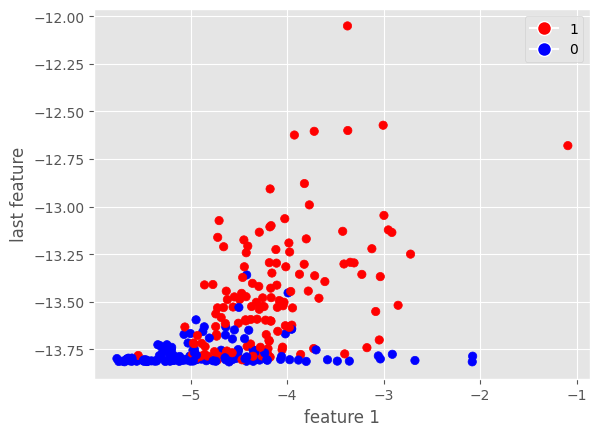

In [21]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.show()

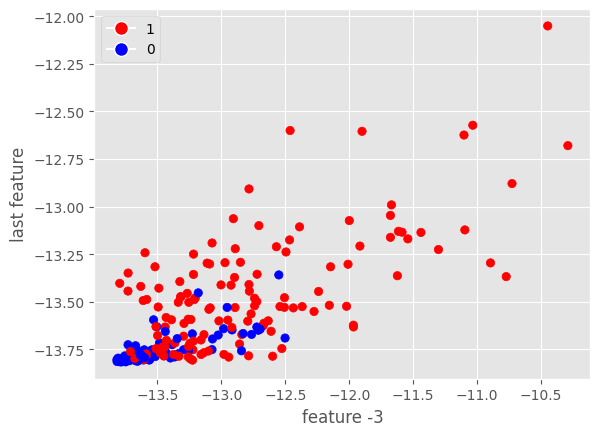

In [22]:
plt.scatter(feats_df['feature_3rdlast'], feats_df['feature_last'], c=feats_df['label'].map({1: 'red', 0: 'blue'}))

plt.xlabel('feature -3')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.show()

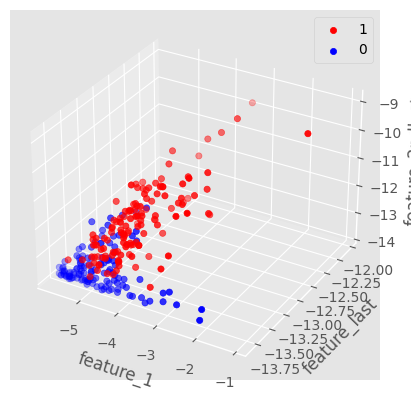

In [23]:
# columns
feat_discriminante = 'feature_1'
feat_y = 'feature_last'
feat_z = 'feature_2ndlast'
label = 'label'


# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {1: 'red', 0: 'blue'}

for label_name, label_color in colors.items():
    subset = feats_df[feats_df[label] == label_name]
    ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

ax.set_xlabel(feat_discriminante)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.legend()

plt.show()


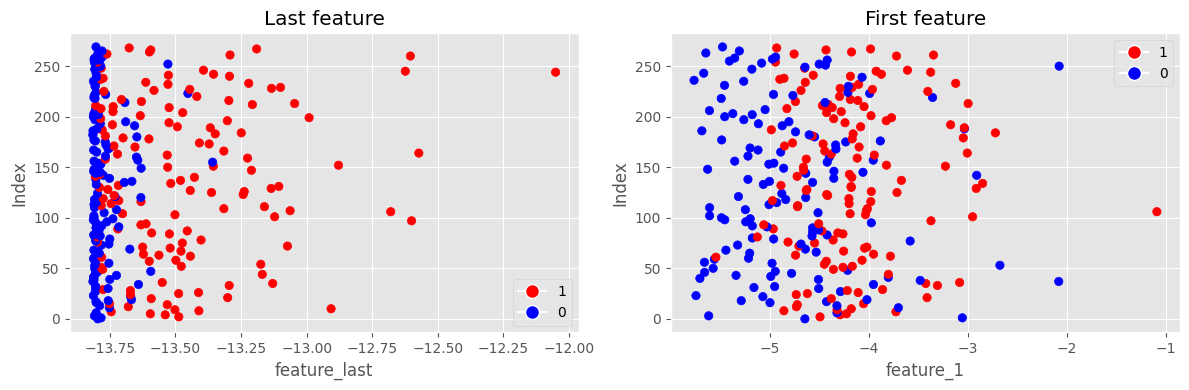

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  

# last feature
axes[0].scatter(feats_df['feature_last'], range(len(feats_df)), c=feats_df['label'].map({1: 'red', 0: 'blue'}))
axes[0].set_xlabel('feature_last')
axes[0].set_ylabel('Index')
axes[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

axes[0].set_title('Last feature')

# first feature 
axes[1].scatter(feats_df['feature_1'], range(len(feats_df)), c=feats_df['label'].map({1: 'red', 0: 'blue'}))
axes[1].set_xlabel('feature_1')
axes[1].set_ylabel('Index')
axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

axes[1].set_title('First feature')

plt.tight_layout()

plt.show()

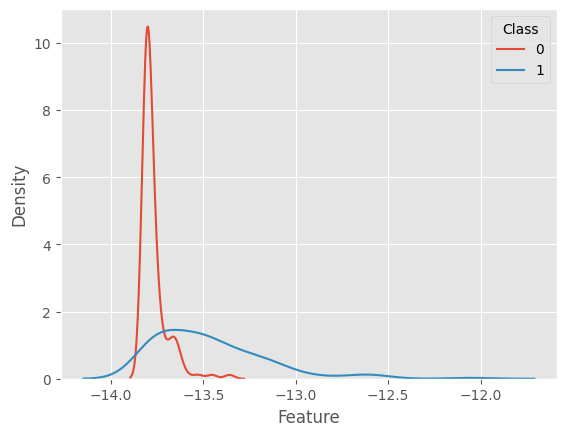

In [25]:
feature = 'feature_last'

for label_name in feats_df['label'].unique():
    subset = feats_df[feats_df[label] == label_name]
    sns.kdeplot(subset[feature], label=label_name)

plt.xlabel('Feature')
plt.ylabel('Density')
plt.legend(title='Class')

plt.show()

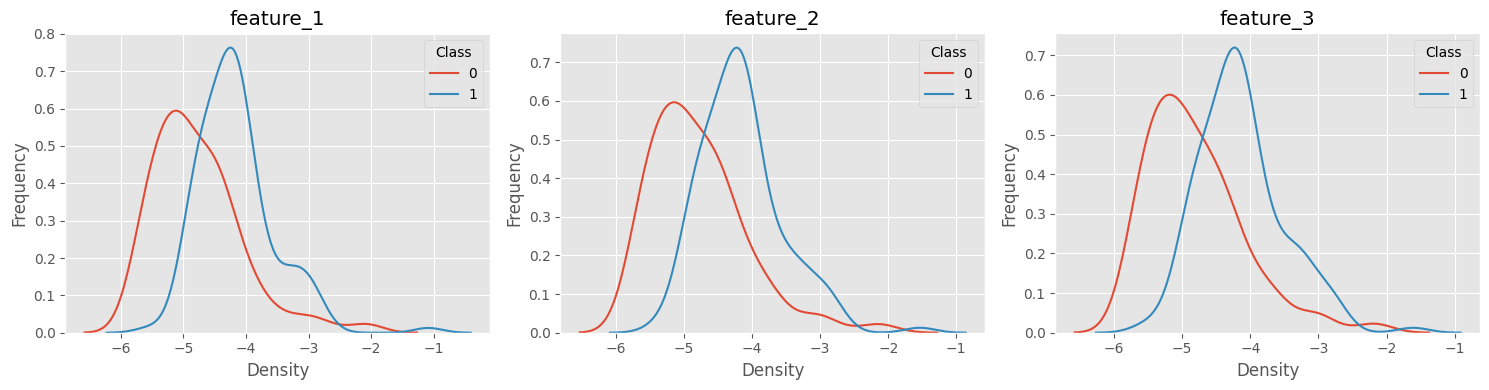

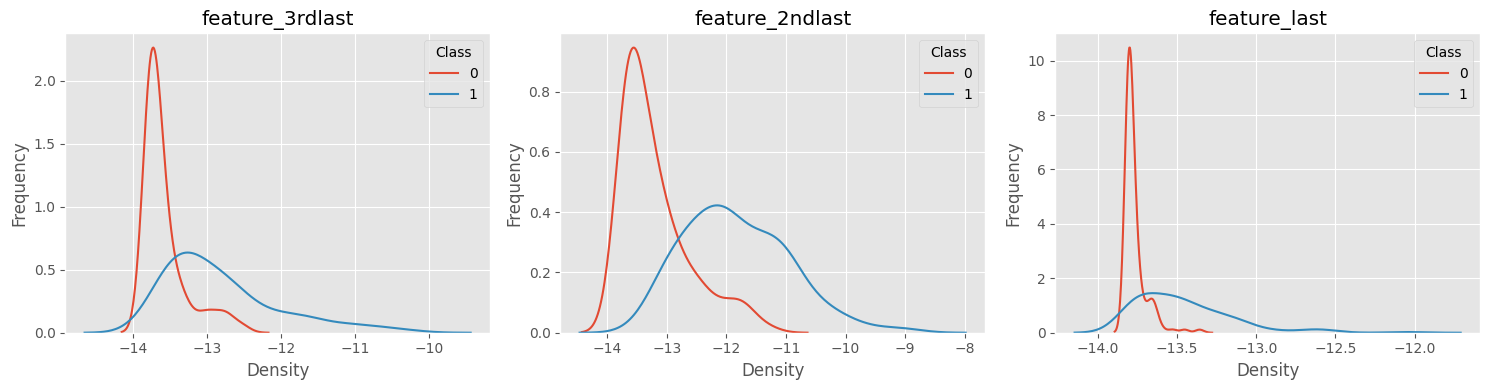

In [26]:
def plot_density(features):
    fig, axes = plt.subplots(1, len(features), figsize=(15, 4))  

    for i, feature in enumerate(features):
        for label_name in feats_df['label'].unique():
            subset = feats_df[feats_df['label'] == label_name]
            sns.kdeplot(subset[feature], label=label_name, ax=axes[i])

        axes[i].set_xlabel('Density')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(feature)

    for ax in axes:
        ax.legend(title='Class')

    plt.tight_layout()
    plt.show()

plot_density(['feature_1', 'feature_2', 'feature_3'])
plot_density(['feature_3rdlast', 'feature_2ndlast', 'feature_last'])

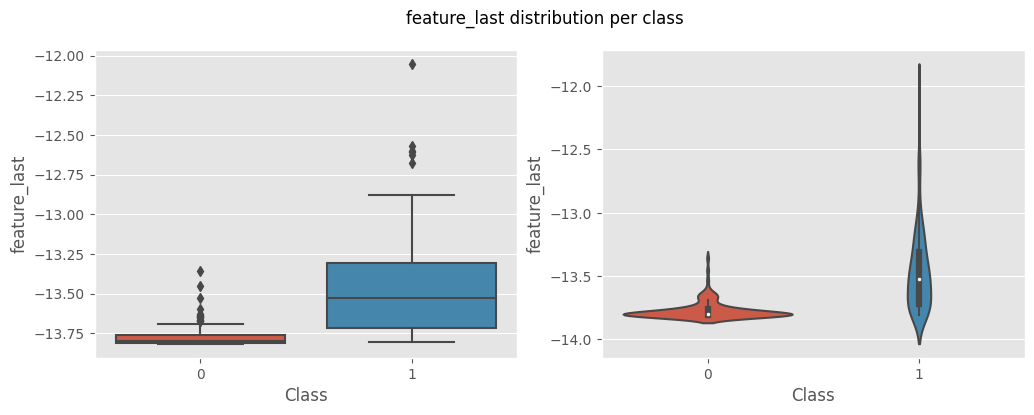

In [27]:
# feature to display
feature = 'feature_last'

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  

sns.boxplot(x='label', y=feature, data=feats_df, ax=axes[0])
axes[0].set_xlabel('Class')
axes[0].set_ylabel(feature)

sns.violinplot(x='label', y=feature, data=feats_df, ax=axes[1])
axes[1].set_xlabel('Class')
axes[1].set_ylabel(feature)

plt.suptitle(feature+' distribution per class')
plt.show()


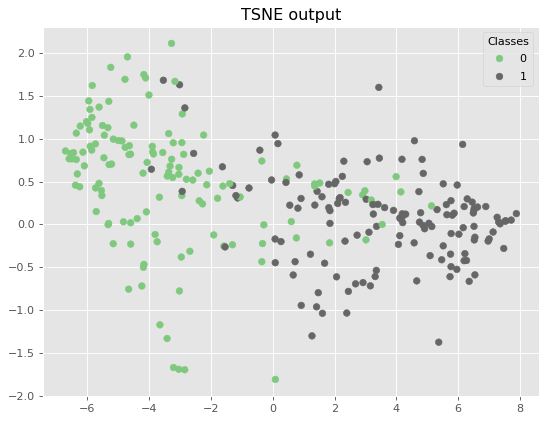

In [28]:
# project coefficients down to 2D using t-SNE and plot
coeffs_embedded = TSNE(n_components=2, perplexity=90, random_state=40).fit_transform(Sc_all_train)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

scatter = plt.scatter(coeffs_embedded[:, 0], coeffs_embedded[:, 1], label=y_train, c=y_train, cmap='Accent')
handles_scatter, labels_scatter = scatter.legend_elements()
legend = plt.legend(handles_scatter, labels_scatter, title='Classes')

plt.title('TSNE output')
plt.show()

In [29]:
print(np.shape(Sc_all_train)[1], 'features')

235 features


Explained variation per principal component: [0.8656153  0.04639138 0.01400304]


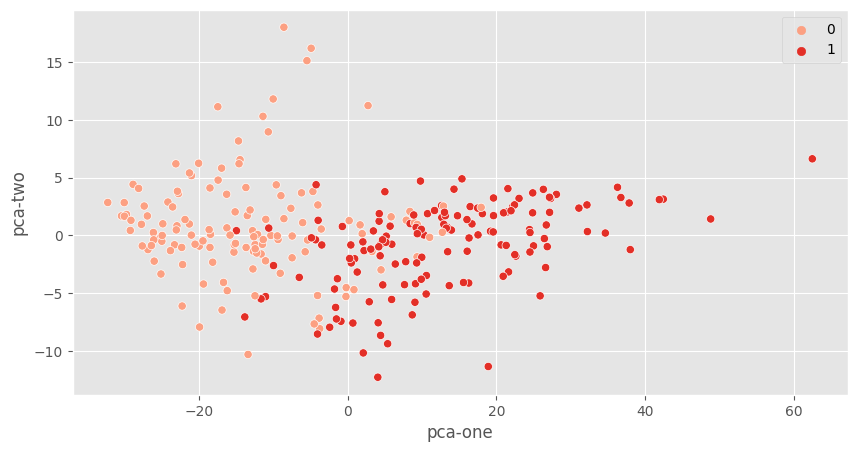

In [30]:
feats = pd.DataFrame(Sc_all_train)

# PCA 
pca = PCA(n_components=3) # 3 PC
pca_result = pca.fit_transform(feats) 

# put PC in feats_df 
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=y_train, 
    palette=sns.color_palette('Reds', 2),
    data=feats,
    legend='full')
plt.show()

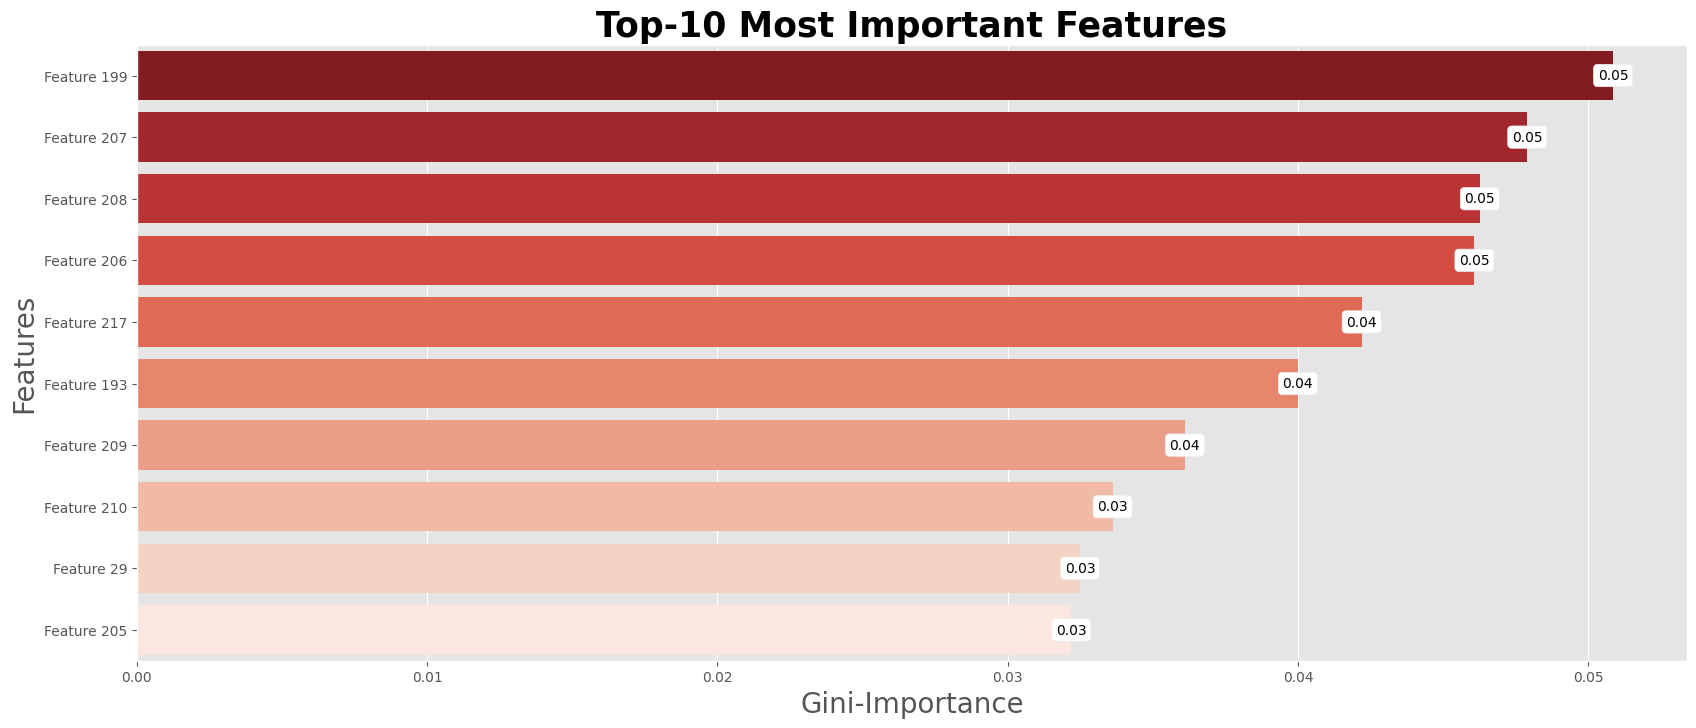

In [31]:
Sc_all_df = pd.DataFrame(Sc_all_train)

rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(Sc_all_df, y_train)

# check which features are the most important in the random forest model
feats = {}
for feature, importance in zip(Sc_all_df.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


# Plot most important features
top_10 = importances[:10]
top_10['Features'] = top_10.Features.astype('str')
top_10['Features'] = ['Feature '+f for f in top_10.Features]

plt.figure(figsize=(20,8))
sns.barplot(x=top_10['Gini-Importance'], y=top_10['Features'], data=top_10,  palette='Reds_r')
plt.xlabel('Gini-Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top-10 Most Important Features', fontsize=25, weight = 'bold')

i=1
for p in top_10['Gini-Importance']:
    x = p
    y = i-1
    lab = round(p, 2)
    plt.annotate(lab, (x,y), 
                bbox=dict(boxstyle='round', fc='w'), 
                va='center', ha='center')
    i+=1

plt.show()

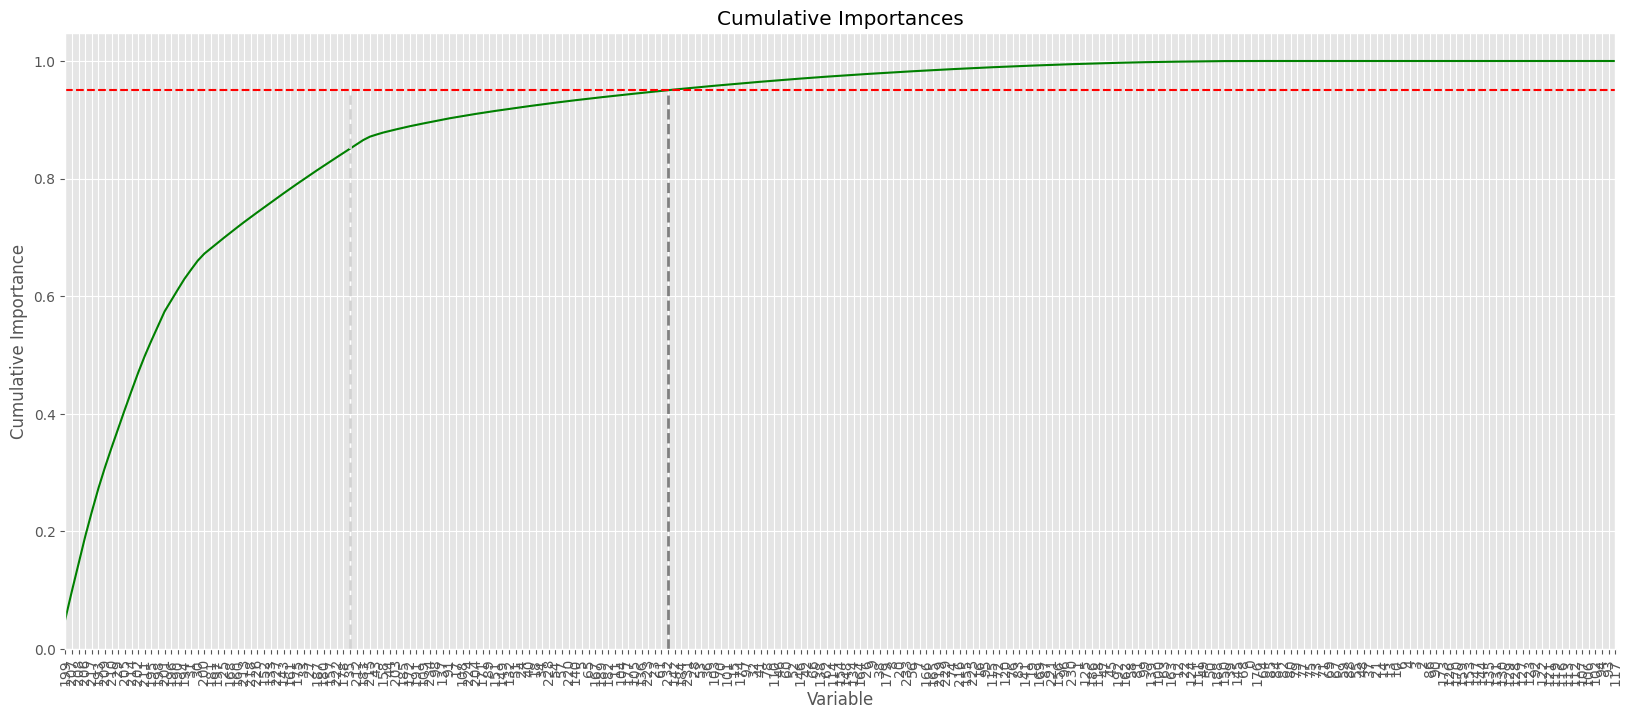

In [32]:
# cumulative importance
cumulative_importances = np.cumsum(importances['Gini-Importance'])

plt.figure(figsize=(20,8))

plt.plot(Sc_all_df.columns, cumulative_importances, 'g-')

# draw line at 95% of importance:
plt.hlines(y = 0.95, xmin=0, xmax=len(importances['Features']), color='r', linestyles='dashed')

# top 10 feats
plt.axvline(x=np.argmax(cumulative_importances >= 0.85), # 85% Gini-Importance reached
            ymin=0, ymax=.9, color='lightgray', linestyle='dashed', linewidth=2)
plt.axvline(x=np.argmax(cumulative_importances >= 0.95), # 95% Gini-Importance reached
            ymin=0, ymax=.9, color='gray', linestyle='dashed', linewidth=2)

plt.xticks(Sc_all_df.columns, importances['Features'], rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.xlim(xmin=0, xmax=len(importances['Features']) - 1)
plt.ylim(ymin=0)

plt.show()

We can reach 95% of cumulative importance with less than half of the scattering features, and most features torwards the end do not add any significant information.

In [33]:
top_10_feats = [int(el.split()[1]) for el in top_10.Features.to_list()]

Sc_top_10 = Sc_all_df[top_10_feats]
Sc_top_10['label'] = y_train

[f'corr feat_{i} - label: '+str(round(np.corrcoef(Sc_top_10[i], Sc_top_10['label'])[0,1], 3)) for i in top_10_feats]

['corr feat_199 - label: 0.769',
 'corr feat_207 - label: 0.734',
 'corr feat_208 - label: 0.786',
 'corr feat_206 - label: 0.78',
 'corr feat_217 - label: 0.769',
 'corr feat_193 - label: 0.745',
 'corr feat_209 - label: 0.764',
 'corr feat_210 - label: 0.718',
 'corr feat_29 - label: 0.739',
 'corr feat_205 - label: 0.797']

Retain features until 95% cumulative importance is reached.

In [34]:
importances['Cumulative-Importance'] = importances['Gini-Importance'].cumsum()
importances

,Features,Gini-Importance,Cumulative-Importance
0,199,0.050858,0.050858
1,207,0.047900,0.098757
2,208,0.046266,0.145023
3,206,0.046079,0.191103
4,217,0.042195,0.233297
...,...,...,...
230,106,0.000000,1.000000
231,102,0.000000,1.000000
232,94,0.000000,1.000000
233,93,0.000000,1.000000


In [35]:
# find the index where cumulative importance first reaches or exceeds 0.95
index_to_cut = importances[importances['Cumulative-Importance'] >= 0.95].index[0]

cut_importances = importances.iloc[:index_to_cut + 1]
cut_importances

,Features,Gini-Importance,Cumulative-Importance
0,199,0.050858,0.050858
1,207,0.047900,0.098757
2,208,0.046266,0.145023
3,206,0.046079,0.191103
4,217,0.042195,0.233297
...,...,...,...
87,136,0.001183,0.945746
88,223,0.001182,0.946928
89,23,0.001169,0.948097
90,61,0.001163,0.949260


In [36]:
col_impo_feats = cut_importances.Features.to_list()
reduced_Sc_all_train = Sc_all_train[:, col_impo_feats]
reduced_Sc_all_train # only most importance features according to Gini-Importance

tensor([[-11.8386, -12.8065, -12.0368,  ...,  -5.7272, -11.9954, -13.5825],
        [-13.0417, -12.5477, -12.5242,  ...,  -6.2016, -10.8057, -13.7542],
        [-10.0349, -11.3785, -10.0363,  ...,  -4.7935,  -9.9867, -13.5823],
        ...,
        [ -9.2198, -11.8197,  -8.9489,  ...,  -3.9796,  -9.2027, -13.0718],
        [-10.6076, -11.7576, -10.8486,  ...,  -5.4519, -10.6436, -13.4976],
        [-13.3457, -13.5612, -13.0581,  ...,  -6.8360, -12.5642, -13.7633]])

In [37]:
reduced_Sc_all_test = Sc_all_test[:, col_impo_feats]

In [38]:
np.shape(reduced_Sc_all_train), np.shape(Sc_all_train)

(torch.Size([270, 92]), torch.Size([270, 235]))

Significant features reduction can be achieved by retaining only features until 95% cumulative importance is reached.  
Classifiers will be trained on both full and reduced set of features to compare performances.

_______

### Classification

#### Standardize

In [30]:
# standardize data using training mean and variance
mu_train = Sc_all_train.mean(dim=0)
std_train = Sc_all_train.std(dim=0)

Sx_train = (Sc_all_train - mu_train) / std_train
Sx_test = (Sc_all_test - mu_train) / std_train

### Train classifiers using wavelets coefficients (all features)
#### Define logistic regression model

In [31]:
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()

# fully connected linear layer + log softmax
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss() # negative log likelihood loss

#### model parameters

In [32]:
batch_size = 32 # number of signals to use in each gradient descent step
num_epochs = 50

In [33]:
# total num of batches
n_samples = Sx_train.shape[0]
n_batches = n_samples // batch_size

#### training

In [34]:
for e in range(num_epochs):
    # random permutation
    perm = torch.randperm(n_samples)

    # for each batch, compute gradient wrt loss
    for i in range(n_batches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_train[idx])
        loss = criterion(resp, y_train[idx])
        loss.backward()
        # take one step / update weights
        optimizer.step()

    
    resp = model.forward(Sx_train)
    avg_loss = criterion(resp, y_train)

    # predict training set classes to compute accuracy while training
    y_hat = resp.argmax(dim=1)
    accuracy = (y_train == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(e, avg_loss, accuracy))

Epoch 0, average loss = 0.321, accuracy = 0.859
Epoch 1, average loss = 0.325, accuracy = 0.859
Epoch 2, average loss = 0.318, accuracy = 0.856
Epoch 3, average loss = 0.305, accuracy = 0.870
Epoch 4, average loss = 0.292, accuracy = 0.878
Epoch 5, average loss = 0.285, accuracy = 0.885
Epoch 6, average loss = 0.283, accuracy = 0.881
Epoch 7, average loss = 0.279, accuracy = 0.881
Epoch 8, average loss = 0.275, accuracy = 0.881
Epoch 9, average loss = 0.273, accuracy = 0.881
Epoch 10, average loss = 0.271, accuracy = 0.881
Epoch 11, average loss = 0.268, accuracy = 0.881
Epoch 12, average loss = 0.265, accuracy = 0.881
Epoch 13, average loss = 0.263, accuracy = 0.881
Epoch 14, average loss = 0.261, accuracy = 0.881
Epoch 15, average loss = 0.258, accuracy = 0.881
Epoch 16, average loss = 0.256, accuracy = 0.881
Epoch 17, average loss = 0.254, accuracy = 0.881
Epoch 18, average loss = 0.251, accuracy = 0.885
Epoch 19, average loss = 0.249, accuracy = 0.885
Epoch 20, average loss = 0.247

#### Evaluate on test set

In [35]:
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('TESTING: neg. ll loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss, acc))

TESTING: neg. ll loss = 0.170, accuracy = 0.948


#### compute probabilities of class-assignemnt

In [36]:
# apply your trained model to test data to get probability estimates for each class 
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs = torch.softmax(logits, dim=1)  # softmax to convert the model's output into probabilities

probs

tensor([[9.8644e-01, 1.3556e-02],
        [9.6464e-01, 3.5360e-02],
        [1.5190e-01, 8.4810e-01],
        [8.7026e-01, 1.2974e-01],
        [8.7109e-02, 9.1289e-01],
        [9.7345e-01, 2.6551e-02],
        [9.7467e-01, 2.5333e-02],
        [7.6643e-01, 2.3357e-01],
        [6.0125e-03, 9.9399e-01],
        [4.1995e-03, 9.9580e-01],
        [9.9906e-01, 9.4468e-04],
        [9.0548e-01, 9.4520e-02],
        [3.6720e-01, 6.3280e-01],
        [1.0309e-01, 8.9691e-01],
        [9.9664e-01, 3.3629e-03],
        [9.7334e-01, 2.6656e-02],
        [2.9492e-02, 9.7051e-01],
        [9.7284e-01, 2.7155e-02],
        [9.9780e-01, 2.2045e-03],
        [9.3959e-01, 6.0412e-02],
        [9.7958e-01, 2.0417e-02],
        [4.1120e-01, 5.8880e-01],
        [9.4493e-01, 5.5074e-02],
        [8.0735e-03, 9.9193e-01],
        [8.8848e-02, 9.1115e-01],
        [2.1151e-01, 7.8849e-01],
        [2.6074e-01, 7.3926e-01],
        [8.6715e-01, 1.3285e-01],
        [3.6396e-02, 9.6360e-01],
        [9.395

#### confusion matrix

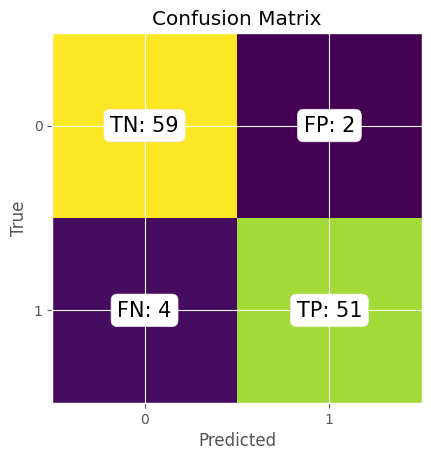

In [37]:
# confusion matrix

preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

#### ROC curve

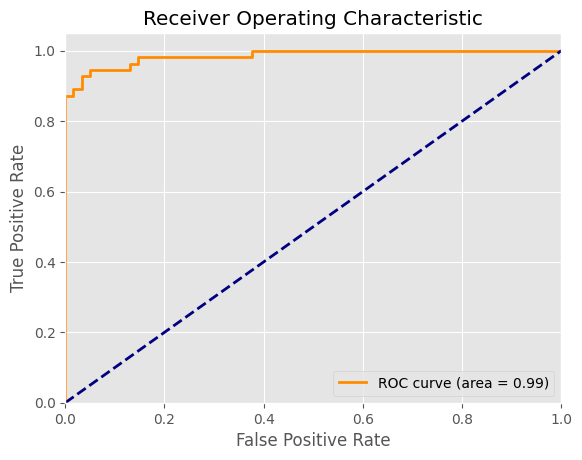

In [38]:
fpr, tpr, thresholds = roc_curve(true_test, probs[:, 1].numpy()) # probs positive outcome only

roc_auc = roc_auc_score(true_test, probs[:, 1].numpy())

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [39]:
# precision, recall, and F1-score
# NOTE: since the 'event' class is 'more important' to be predicted correctly,
# focus on recall rather than precision 


precision = precision_score(true_test, preds_test)

recall = recall_score(true_test, preds_test)

f1 = f1_score(true_test, preds_test)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.962
Recall: 0.927
F1-score: 0.944
Specificity: 0.967


Check predictions and prediction errors

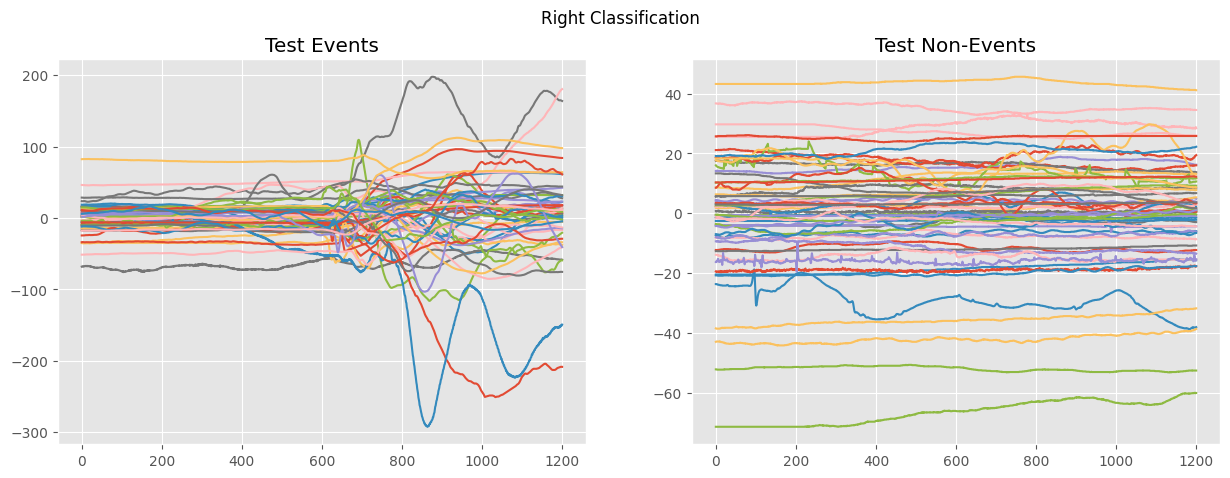

In [40]:
seq_train, seq_test, _, _ = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=2)
res_test = pd.DataFrame({'test_seq':[seq for seq in seq_test], 'true_lab':y_test, 'pred_lab':preds_test})

right_classif = res_test[res_test.true_lab == res_test.pred_lab]
zero_class = right_classif[right_classif.true_lab == 0]
one_class = right_classif[right_classif.true_lab == 1]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

for ev in one_class.test_seq.to_list():
    ax1.plot(ev)
ax1.set_title('Test Events')

for non_ev in zero_class.test_seq.to_list():
    ax2.plot(non_ev)
ax2.set_title('Test Non-Events')

plt.suptitle('Right Classification')

plt.show()

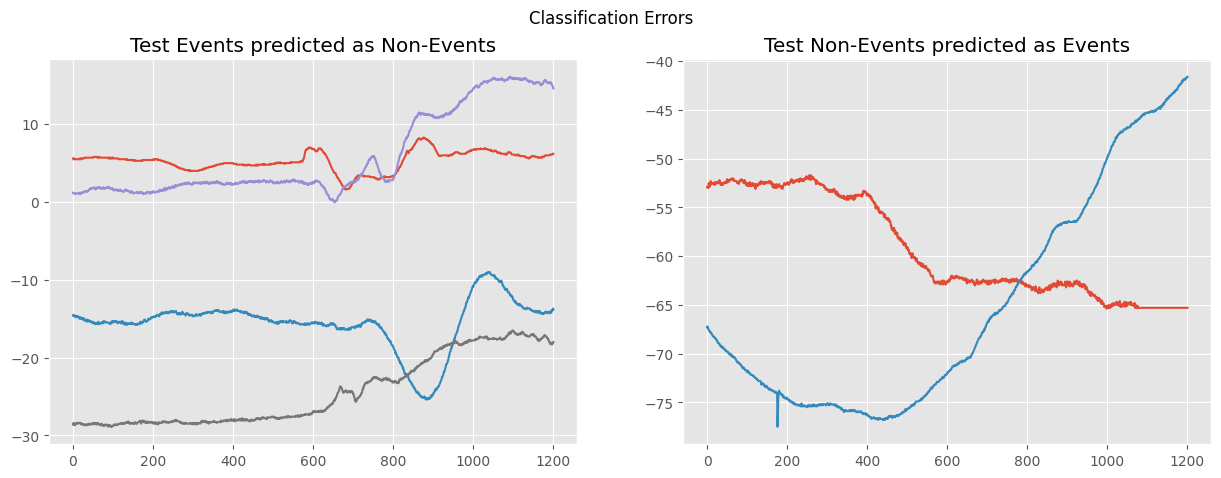

In [50]:
wrong_classif = res_test[res_test.true_lab != res_test.pred_lab]
zero_class = wrong_classif[wrong_classif.true_lab == 0]
one_class = wrong_classif[wrong_classif.true_lab == 1]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

for ev in one_class.test_seq.to_list():
    ax1.plot(ev)
ax1.set_title('Test Events predicted as Non-Events')

for non_ev in zero_class.test_seq.to_list():
    ax2.plot(non_ev)
ax2.set_title('Test Non-Events predicted as Events')

plt.suptitle('Classification Errors')

plt.show()

______

#### Repeat training of the same model but using REDUCED features (95% Gini-importance)

In [51]:
# TRAIN WITH REDUCED FEATURES
# standardize data using training mean and variance
mu_train = reduced_Sc_all_train.mean(dim=0)
std_train = reduced_Sc_all_train.std(dim=0)

reduced_Sx_train = (reduced_Sc_all_train - mu_train) / std_train
reduced_Sx_test = (reduced_Sc_all_test - mu_train) / std_train


# ------------------------------------------------

# shape
num_input = reduced_Sx_train.shape[-1]
num_classes = y_train.unique().numel()

# fully connected linear layer + log softmax
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss() # negative log likelihood loss

# total num of batches
n_samples = reduced_Sx_train.shape[0]
n_batches = n_samples // batch_size

# ------------------------------------------------

# TRAINING
for e in range(num_epochs):
    # random permutation
    perm = torch.randperm(n_samples)

    # for each batch, compute gradient wrt loss
    for i in range(n_batches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(reduced_Sx_train[idx])
        loss = criterion(resp, y_train[idx])
        loss.backward()
        # take one step
        optimizer.step()

    
    resp = model.forward(reduced_Sx_train)
    avg_loss = criterion(resp, y_train)

    # predict training set classes to compute accuracy while training
    y_hat = resp.argmax(dim=1)
    accuracy = (y_train == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(e, avg_loss, accuracy))

Epoch 0, average loss = 0.416, accuracy = 0.867
Epoch 1, average loss = 0.311, accuracy = 0.885
Epoch 2, average loss = 0.286, accuracy = 0.885
Epoch 3, average loss = 0.280, accuracy = 0.885
Epoch 4, average loss = 0.278, accuracy = 0.881
Epoch 5, average loss = 0.277, accuracy = 0.881
Epoch 6, average loss = 0.276, accuracy = 0.885
Epoch 7, average loss = 0.275, accuracy = 0.885
Epoch 8, average loss = 0.274, accuracy = 0.889
Epoch 9, average loss = 0.273, accuracy = 0.889
Epoch 10, average loss = 0.272, accuracy = 0.889
Epoch 11, average loss = 0.270, accuracy = 0.889
Epoch 12, average loss = 0.269, accuracy = 0.889
Epoch 13, average loss = 0.268, accuracy = 0.889
Epoch 14, average loss = 0.267, accuracy = 0.889
Epoch 15, average loss = 0.266, accuracy = 0.885
Epoch 16, average loss = 0.265, accuracy = 0.885
Epoch 17, average loss = 0.264, accuracy = 0.885
Epoch 18, average loss = 0.263, accuracy = 0.885
Epoch 19, average loss = 0.262, accuracy = 0.885
Epoch 20, average loss = 0.261

#### Evaluate on test set

In [52]:
resp = model.forward(reduced_Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('TESTING: neg. ll loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss, acc))

TESTING: neg. ll loss = 0.185, accuracy = 0.940


#### probabilities

In [53]:
# apply your trained model to test data to get probability estimates for each class 
model.eval() 
with torch.no_grad():
    logits = model(reduced_Sx_test)
    probs_reducted_feats = torch.softmax(logits, dim=1)  # softmax to convert the model's output into probabilities

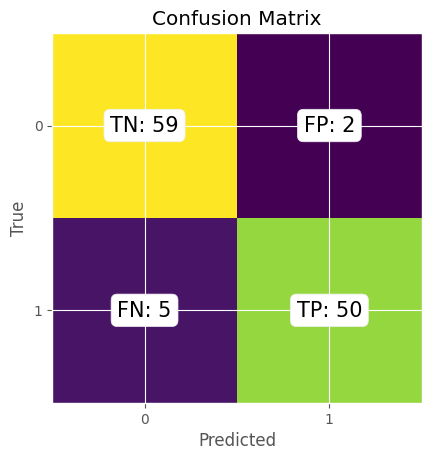

In [54]:
# confusion matrix

preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

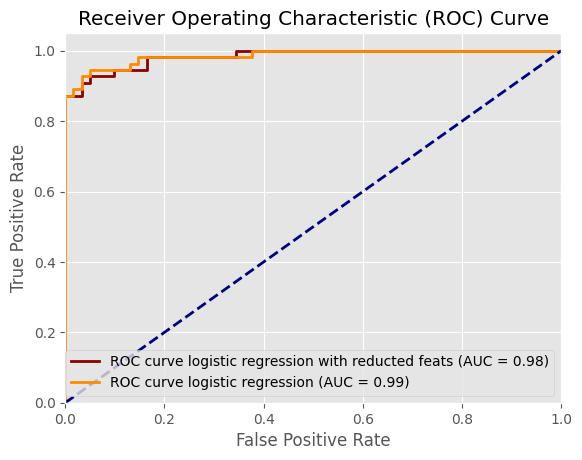

In [55]:
# ROC
fpr_reduced, tpr_reduced, thresholds_reduced = roc_curve(true_test, probs_reducted_feats[:, 1].numpy()) # probs positive outcome only
# AUC
auc_reduced = roc_auc_score(true_test, probs_reducted_feats[:, 1].numpy())


# plot ROC
plt.figure()

# logistic regression with reducted feats
plt.plot(fpr_reduced, tpr_reduced, color='darkred', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve logistic regression (AUC = {roc_auc:.2f})') # first logistic regression

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [56]:
precision = precision_score(true_test, preds_test)

recall = recall_score(true_test, preds_test)

f1 = f1_score(true_test, preds_test)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.962
Recall: 0.909
F1-score: 0.935
Specificity: 0.967


_______

### Define SVC model

In [41]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 10. ], # regularization
        'class_weight':[{1:2, 0:1},  # give weight 2 to class 1 (event)
                        {1:1, 0:.5}],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }
n_splits, n_repeats = 10, 5


# 10 folds CV
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(Sx_train, y_train)
gridCV.best_params_

{'C': 1.0, 'class_weight': {1: 1, 0: 0.5}, 'gamma': 'scale', 'kernel': 'rbf'}

In [42]:
svc = SVC(**gridCV.best_params_, probability=True).fit(Sx_train, y_train)

In [43]:
svm_preds = svc.predict(Sx_test)
confusion = confusion_matrix(y_test, svm_preds)
confusion

array([[53,  8],
       [ 4, 51]])

In [44]:
# probabilities class assignment
svc_probs = svc.predict_proba(Sx_test)
svc_probs

array([[0.9767872 , 0.0232128 ],
       [0.97907004, 0.02092996],
       [0.09319688, 0.90680312],
       [0.9589504 , 0.0410496 ],
       [0.1040108 , 0.8959892 ],
       [0.97060974, 0.02939026],
       [0.97421333, 0.02578667],
       [0.93044075, 0.06955925],
       [0.13103804, 0.86896196],
       [0.13259445, 0.86740555],
       [0.9622373 , 0.0377627 ],
       [0.93277241, 0.06722759],
       [0.27216575, 0.72783425],
       [0.24313278, 0.75686722],
       [0.97401633, 0.02598367],
       [0.98008566, 0.01991434],
       [0.09401069, 0.90598931],
       [0.97722291, 0.02277709],
       [0.9784231 , 0.0215769 ],
       [0.96909046, 0.03090954],
       [0.98413904, 0.01586096],
       [0.32487595, 0.67512405],
       [0.87224122, 0.12775878],
       [0.13602156, 0.86397844],
       [0.11549101, 0.88450899],
       [0.10848282, 0.89151718],
       [0.17313933, 0.82686067],
       [0.7767359 , 0.2232641 ],
       [0.11280018, 0.88719982],
       [0.96702985, 0.03297015],
       [0.

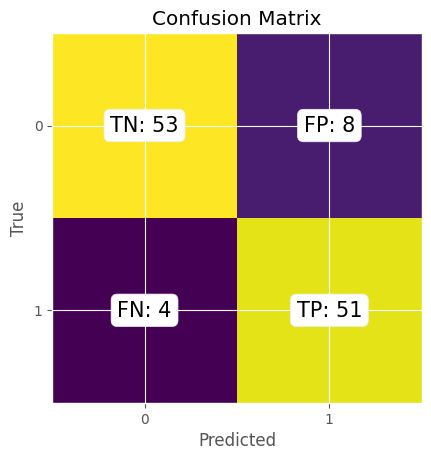

In [45]:
plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

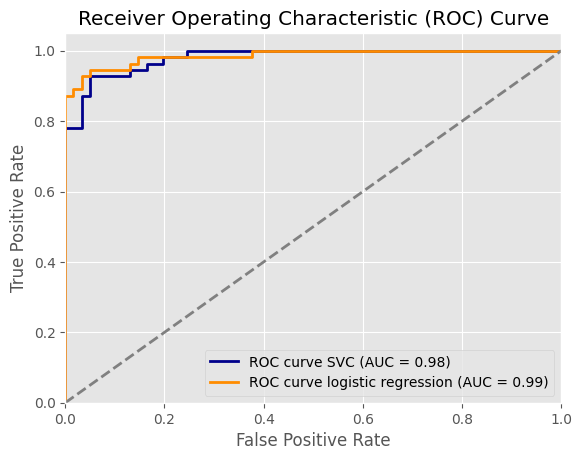

In [47]:
# ROC
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, svc_probs[:, 1])

# AUC
roc_auc_svm = roc_auc_score(y_test, svc_probs[:, 1])


# plot ROC curve
plt.figure()
# SVC
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw=2, label=f'ROC curve SVC (AUC = {roc_auc_svm:.2f})')

# logistic regression with reducted feats
# plt.plot(fpr_reduced, tpr_reduced, color='darkred', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve logistic regression (AUC = {roc_auc:.2f})') # first logistic regression

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [48]:
accuracy_score(y_test, svm_preds)

0.896551724137931

In [49]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        61
           1       0.86      0.93      0.89        55

    accuracy                           0.90       116
   macro avg       0.90      0.90      0.90       116
weighted avg       0.90      0.90      0.90       116



In [50]:
precision = precision_score(y_test, svm_preds)

recall = recall_score(y_test, svm_preds)

f1 = f1_score(y_test, svm_preds)

tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

print('Precision: {:1.3f}\nRecall: {:1.3f}\nF1-score: {:1.3f}\nSpecificity: {:1.3f}'.format(precision, recall, f1, specificity))

Precision: 0.864
Recall: 0.927
F1-score: 0.895
Specificity: 0.869


______

#### Random Forest

In [51]:
# RF
rf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rf.fit(Sx_train.numpy(), y_train.numpy()) # must be numpy array

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=2),
             estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [52]:
grid_search_rf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [53]:
grid_search_rf.best_score_

0.8822222222222221

In [54]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=2).fit(Sx_train.numpy(), y_train.numpy())

In [55]:
y_pred_rf = rf.predict(Sx_test.numpy())
acc_rf_full = accuracy_score(y_test.numpy(), y_pred_rf)
print('Test Accuracy: ', acc_rf_full)

Test Accuracy:  0.9310344827586207


In [56]:
# get probabilities
probs_rf = rf.predict_proba(Sx_test.numpy())

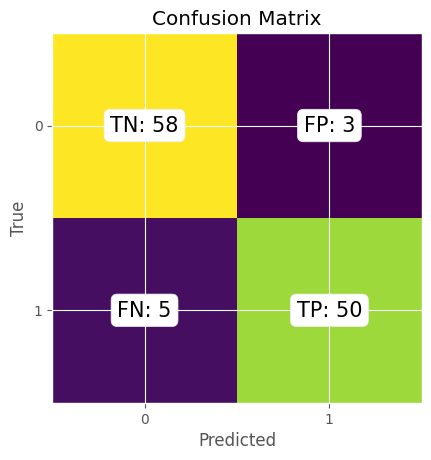

In [57]:
# confusion matrix
confusion = confusion_matrix(y_test, y_pred_rf)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

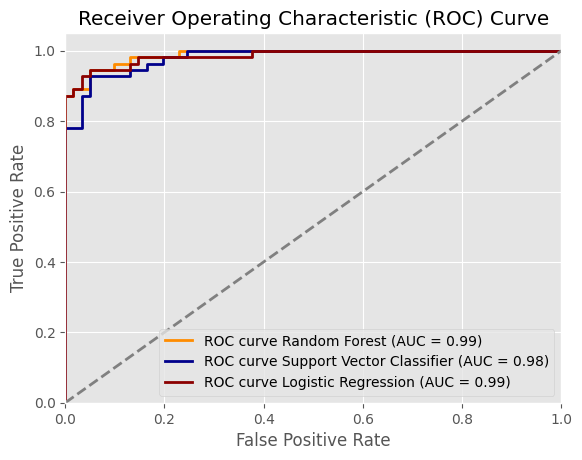

In [58]:
# ROC
fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test, probs_rf[:, 1])

# AUC
roc_auc_ts = roc_auc_score(y_test, probs_rf[:, 1])


# plot ROC curve
plt.figure()
# Random Forecast Classifier
plt.plot(fpr_ts, tpr_ts, color='darkorange', lw=2, label=f'ROC curve Random Forest (AUC = {roc_auc_ts:.2f})')

# SVC
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw=2, label=f'ROC curve Support Vector Classifier (AUC = {roc_auc_svm:.2f})')

# logistic regression with reducted feats
# plt.plot(fpr_reduced, tpr_reduced, color='darkgreen', lw=2, label=f'ROC curve logistic regression with reducted feats (AUC = {auc_reduced:.2f})')

# first logistic regression
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve Logistic Regression (AUC = {roc_auc:.2f})') 

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()